In [1]:
import numpy as np
import pandas as pd

FILEPATH_TRAIN = './data/training.txt'
FILEPATH_TEST = './data/test.txt'
HEADER = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship',
          'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'target']

train = pd.read_csv(FILEPATH_TRAIN, sep='\t', names=HEADER)
train_temp = train.loc[(train['capital_gain'] == 0) & (train['capital_loss'] == 0)]
print("Percentage of data with capital gain/loss equal to 0: {}%".format(100 * len(train_temp) / len(train)))

Percentage of data with capital gain/loss equal to 0: 87.00592733638402%


I remove from the dataset the following columns:
1. fnlwgt: the information refers to the number of data with the same features.
2. education: the information is contained in the column 'education_num'.
3. relationship: the information is contained in the column 'marital_status'.
4. capital_gain/loss: for most of the data, these columns are set to 0..

In [2]:
train2 = train.drop(['fnlwgt', 'education', 'relationship', 'capital_gain', 'capital_loss'], axis=1)
train2.head()

,age,workclass,education_num,marital_status,occupation,race,sex,hours_per_week,native_country,target
0,39,State-gov,13,Never-married,Adm-clerical,White,Male,40,United-States,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,White,Male,13,United-States,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,White,Male,40,United-States,<=50K
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Black,Male,40,United-States,<=50K
4,28,Private,13,Married-civ-spouse,Prof-specialty,Black,Female,40,Cuba,<=50K


In [3]:
# some information on numerical attributes.
train_num = train2.select_dtypes(include=np.number)
for c in train_num.columns:
    train_num_col = train_num[c].to_numpy()
    print("{}: mean = {}, std = {}, min = {}, max = {}.".format(c, train_num_col.mean(), train_num_col.std(),
                                                                train_num_col.min(), train_num_col.max()))

age: mean = 38.58164675532078, std = 13.640223092304275, min = 17, max = 90.
education_num: mean = 10.0806793403151, std = 2.5726808256012865, min = 1, max = 16.
hours_per_week: mean = 40.437455852092995, std = 12.34723907570799, min = 1, max = 99.


In [4]:
from scipy import stats

Z_THRESHOLD = 3

z = np.abs(stats.zscore(train_num))

counter = np.count_nonzero(z > Z_THRESHOLD, axis=0)
for cat, c in zip(train_num.columns, counter):
    print("Possible outliers for {}: {}%.".format(cat, 100 * c / len(train_num)))

Possible outliers for age: 0.371610208531679%.
Possible outliers for education_num: 0.672583765854857%.
Possible outliers for hours_per_week: 1.3513098492061055%.


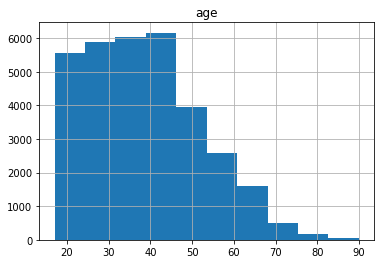

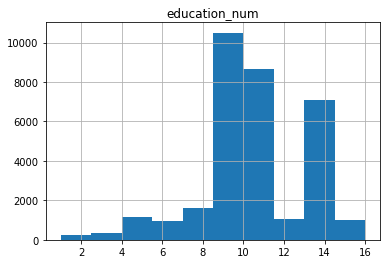

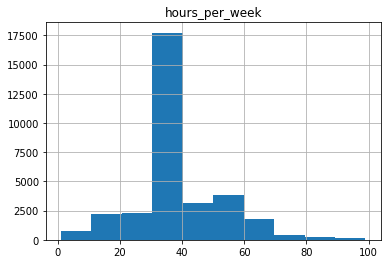

In [8]:
for col in train_num.columns:
    train_num.hist(column=col)

In [16]:
# all the numerical variables have reasonable values, let's normalize.
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(train_num)
train_num_normalized = pd.DataFrame(np_scaled, columns = train_num.columns)

# replace normalized columns in the dataframe
for col in train_num_normalized.columns:
    train2[col] = train_num_normalized[col]
    
train2.head()

,age,workclass,education_num,marital_status,occupation,race,sex,hours_per_week,native_country,target
0,0.301370,State-gov,0.800000,Never-married,Adm-clerical,White,Male,0.397959,United-States,<=50K
1,0.452055,Self-emp-not-inc,0.800000,Married-civ-spouse,Exec-managerial,White,Male,0.122449,United-States,<=50K
2,0.287671,Private,0.533333,Divorced,Handlers-cleaners,White,Male,0.397959,United-States,<=50K
3,0.493151,Private,0.400000,Married-civ-spouse,Handlers-cleaners,Black,Male,0.397959,United-States,<=50K
4,0.150685,Private,0.800000,Married-civ-spouse,Prof-specialty,Black,Female,0.397959,Cuba,<=50K


In [27]:
# some information on categorical attributes.
columns_cat = []
for c in train2.columns:
    if c not in train_num.columns:
        columns_cat.append(c)
        
columns_null = []
for c in columns_cat:
    train_cat_col = train[c].values
    print("{} - {}.".format(c, set(train_cat_col)))
    if ' ?' in set(train_cat_col):
        columns_null.append(c)

workclass - {' Self-emp-inc', ' ?', ' Federal-gov', ' State-gov', ' Self-emp-not-inc', ' Without-pay', ' Local-gov', ' Never-worked', ' Private'}.
marital_status - {' Divorced', ' Married-civ-spouse', ' Widowed', ' Never-married', ' Married-AF-spouse', ' Separated', ' Married-spouse-absent'}.
occupation - {' Tech-support', ' Other-service', ' Craft-repair', ' Transport-moving', ' Farming-fishing', ' ?', ' Protective-serv', ' Adm-clerical', ' Armed-Forces', ' Priv-house-serv', ' Machine-op-inspct', ' Prof-specialty', ' Handlers-cleaners', ' Sales', ' Exec-managerial'}.
race - {' Black', ' Amer-Indian-Eskimo', ' Other', ' White', ' Asian-Pac-Islander'}.
sex - {' Male', ' Female'}.
native_country - {' Haiti', ' Hong', ' Poland', ' Guatemala', ' Ecuador', ' Jamaica', ' Taiwan', ' Honduras', ' United-States', ' India', ' Ireland', ' Peru', ' England', ' Laos', ' Cambodia', ' Dominican-Republic', ' Thailand', ' China', ' Canada', ' Cuba', ' ?', ' Nicaragua', ' Hungary', ' Italy', ' Mexico', 

In [28]:
for c in columns_null:
    col = train2[c].values
    print("{}: null values = {:.2f}%.".format(c, 100 * len([v for v in col if v == " ?"])/len(train2)))

workclass: null values = 5.64%.
occupation: null values = 5.66%.
native_country: null values = 1.79%.


In [68]:
print("Shape before removing null values: {}.".format(train2.shape))
train3 = train2[(train2['workclass'] != " ?") & (train2['occupation'] != " ?") & 
                     (train2['native_country'] != " ?")]
print("Shape after removing null values: {}.".format(train3.shape))

for c in columns_null:
    col = train3[c].values
    print("{}: null values = {:.2f}%.".format(c, 100 * len([v for v in col if v == " ?"])/len(train3)))

Shape before removing null values: (32561, 10).
Shape after removing null values: (30162, 10).
workclass: null values = 0.00%.
occupation: null values = 0.00%.
native_country: null values = 0.00%.


In [69]:
for c in columns_cat:
    vc = train3[c].value_counts()
    print (vc)

 Private             22286
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
Name: workclass, dtype: int64
 Married-civ-spouse       14065
 Never-married             9726
 Divorced                  4214
 Separated                  939
 Widowed                    827
 Married-spouse-absent      370
 Married-AF-spouse           21
Name: marital_status, dtype: int64
 Prof-specialty       4038
 Craft-repair         4030
 Exec-managerial      3992
 Adm-clerical         3721
 Sales                3584
 Other-service        3212
 Machine-op-inspct    1966
 Transport-moving     1572
 Handlers-cleaners    1350
 Farming-fishing       989
 Tech-support          912
 Protective-serv       644
 Priv-house-serv       143
 Armed-Forces            9
Name: occupation, dtype: int64
 White                 25933
 Black                  2817
 Asian-Pac-Islander      895
 Amer-Indian-Eskimo      2

As a first approach, I assign two possible values to 'native_country': United-States and Other.

In [82]:
def native_country_corrector(x):
    x = x.strip()
    return x if x == 'United-States' else 'Other'

column_native = train3['native_country']
column_native = list(map(native_country_corrector, column_native))
train3.head()

,age,workclass,education_num,marital_status,occupation,race,sex,hours_per_week,native_country,target
0,0.301370,State-gov,0.800000,Never-married,Adm-clerical,White,Male,0.397959,United-States,<=50K
1,0.452055,Self-emp-not-inc,0.800000,Married-civ-spouse,Exec-managerial,White,Male,0.122449,United-States,<=50K
2,0.287671,Private,0.533333,Divorced,Handlers-cleaners,White,Male,0.397959,United-States,<=50K
3,0.493151,Private,0.400000,Married-civ-spouse,Handlers-cleaners,Black,Male,0.397959,United-States,<=50K
4,0.150685,Private,0.800000,Married-civ-spouse,Prof-specialty,Black,Female,0.397959,Other,<=50K
